In [1]:
%matplotlib inline

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import theano

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def unconditionalProbability(Ptrans):
    """Compute the unconditional probability for the states of a Markov chain."""

    m = Ptrans.shape[0]

    P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

    I = np.eye(m)
    U = np.ones((m, m))
    u = np.ones(m)

    return np.linalg.solve((I - P + U).T, u)

In [4]:
data = np.loadtxt('test_data.txt',
                 dtype=np.dtype([('state', np.uint8),
                                 ('emission', np.float)]),
                 delimiter=',',
                 skiprows=1)

data['state'] = data['state']-1
data['state']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

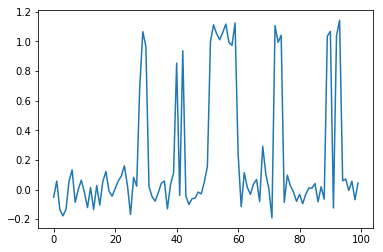

In [5]:
measurement = data['state']*1.0 + 0.1*np.random.randn(len(data['state']))
plt.plot(measurement[:100])

# Simple Two States Model

In [6]:

# Two state model for simplicity.
N_states = 2
N_chain = len(data)

# Transition probability stochastic
theta = np.ones(N_states) + 1.
alphaA = 2.1
betaA = 1.1
alphaS = 11.0
betaS = 1.

In [7]:
class HMMStates(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        # for more than two states we may use tt.choose()
#        length = x.shape[0]
        PT = tt.stack((P1,P2))
        
        P = PT[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P, shape=(N_chain-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [8]:
class HMMGaussianEmissions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, S1=None, S2=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.S1 = S1
        self.A2 = A2
        self.S2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        S1 = self.S1
        A2 = self.A2
        S2 = self.S2
        states = self.states
        
#        length = x.shape[0]
#        AT = tt.tile(A.T,(length,1,1))
#        ST = tt.tile(S.T,(length,1,1))
        
#        AS = tt.switch(states,AT.T)        
#        SS = tt.switch(states,ST.T)
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [9]:
theano.config.exception_verbosity = 'high'
from scipy import optimize
with pm.Model() as model:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    A1 = pm.Normal('A1',mu=0, sd=1)
    A2 = pm.Normal('A2',mu=1, sd=1)
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, shape=N_chain)
    
    emission = HMMGaussianEmissions('emission',
                                    A1=A1,
                                    A2=A1,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = measurement)
    
    # start = pm.find_MAP(fmin=optimize.fmin_powell)
    # step1 = pm.Metropolis(vars=[P1, P2, A1, A2, S1, S2, PA, emission])
    # step2 = pm.BinaryGibbsMetropolis(vars=[states])
    # trace = pm.sample(10000, start=start, step=[step1, step2])

In [10]:
with model:
    mean_field = pm.fit(method='advi', n=5000, callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])

  0%|          | 0/5000 [00:00<?, ?it/s]


IndexError: index 2 is out of bounds for size 2
Apply node that caused the error: AdvancedSubtensor1(Join.0, Subtensor{:int64:}.0)
Toposort index: 139
Inputs types: [TensorType(float64, matrix), TensorType(int64, vector)]
Inputs shapes: [(2, 2), (999,)]
Inputs strides: [(16, 8), (8,)]
Inputs values: [array([[0.71074877, 0.28925123],
       [0.46346831, 0.53653169]]), 'not shown']
Inputs type_num: [12, 7]
Outputs clients: [[Sum{axis=[1], acc_dtype=float64}(AdvancedSubtensor1.0), InplaceDimShuffle{1,0}(AdvancedSubtensor1.0), Elemwise{true_div,no_inplace}(AdvancedSubtensor1.0, InplaceDimShuffle{0,x}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/nilavro/irleak/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nilavro/irleak/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-72e9270fab3c>", line 17, in <module>
    states = HMMStates('states',PA,P1,P2, shape=N_chain)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/distribution.py", line 37, in __new__
    return model.Var(name, dist, data, total_size)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py", line 752, in Var
    total_size=total_size, model=self)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py", line 1133, in __init__
    self.logp_sum_unscaledt = distribution.logp_sum(self)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/distribution.py", line 114, in logp_sum
    return tt.sum(self.logp(*args, **kwargs))
  File "<ipython-input-7-53291351e5c2>", line 35, in logp
    P = PT[x[:-1]]
  File "<ipython-input-9-72e9270fab3c>", line 17, in <module>
    states = HMMStates('states',PA,P1,P2, shape=N_chain)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/distribution.py", line 37, in __new__
    return model.Var(name, dist, data, total_size)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py", line 752, in Var
    total_size=total_size, model=self)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py", line 1133, in __init__
    self.logp_sum_unscaledt = distribution.logp_sum(self)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/distribution.py", line 114, in logp_sum
    return tt.sum(self.logp(*args, **kwargs))
  File "<ipython-input-7-53291351e5c2>", line 39, in logp
    ou_like = pm.Categorical.dist(P, shape=(N_chain-1,2)).logp(x_i)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/distribution.py", line 47, in dist
    dist.__init__(*args, **kwargs)
  File "/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/distributions/discrete.py", line 510, in __init__
    self.p = (p.T / tt.sum(p, -1)).T

Debugprint of the apply node: 
AdvancedSubtensor1 [id A] <TensorType(float64, matrix)> ''   
 |Join [id B] <TensorType(float64, matrix)> ''   
 | |TensorConstant{0} [id C] <TensorType(int8, scalar)>
 | |InplaceDimShuffle{x,0} [id D] <TensorType(float64, row)> ''   
 | | |Elemwise{mul,no_inplace} [id E] <TensorType(float64, vector)> 'P1'   
 | |InplaceDimShuffle{x,0} [id F] <TensorType(float64, row)> ''   
 |   |Elemwise{mul,no_inplace} [id G] <TensorType(float64, vector)> 'P2'   
 |Subtensor{:int64:} [id H] <TensorType(int64, vector)> ''   
   |Elemwise{Cast{int64}} [id I] <TensorType(int64, vector)> 'states_vi_replacement'   
   |Constant{-1} [id J] <int64>

Storage map footprint:
 - <TensorType(int32, matrix)>, Shared Input, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - mrg_uniform{TensorType(float64, vector),inplace}.0, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1006, 10), ElemSize: 8 Byte(s), TotalSize: 80480 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (1006, 10), ElemSize: 8 Byte(s), TotalSize: 80480 Byte(s)
 - Alloc.0, Shape: (999, 2), ElemSize: 8 Byte(s), TotalSize: 15984 Byte(s)
 - TensorConstant{(1006,) of -1.0}, Shape: (1006,), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - Elemwise{Composite{((i0 * i1) + i2)}}.0, Shape: (1, 1006), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - rho, Shared Input, Shape: (1006,), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - InplaceDimShuffle{x,0}.0, Shape: (1, 1006), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - softplus.0, Shape: (1006,), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - Rebroadcast{0}.0, Shape: (1, 1006), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - mu, Shared Input, Shape: (1006,), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - Alloc.0, Shape: (1006,), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - Rebroadcast{0}.0, Shape: (1, 1006), ElemSize: 8 Byte(s), TotalSize: 8048 Byte(s)
 - TensorConstant{[-5.180537..33881e-01]}, Shape: (1000,), ElemSize: 8 Byte(s), TotalSize: 8000 Byte(s)
 - states_vi_replacement, Shape: (1000,), ElemSize: 8 Byte(s), TotalSize: 8000 Byte(s)
 - Subtensor{int64::}.0, Shape: (999,), ElemSize: 8 Byte(s), TotalSize: 7992 Byte(s)
 - Subtensor{:int64:}.0, Shape: (999,), ElemSize: 8 Byte(s), TotalSize: 7992 Byte(s)
 - TensorConstant{[  0   1  ..6 997 998]}, Shape: (999,), ElemSize: 8 Byte(s), TotalSize: 7992 Byte(s)
 - TensorConstant{(999, 1) of 0.0}, Shape: (999, 1), ElemSize: 8 Byte(s), TotalSize: 7992 Byte(s)
 - Elemwise{Composite{Cast{int8}((GE(i0, i1) * LE(i0, i2)))}}.0, Shape: (999,), ElemSize: 1 Byte(s), TotalSize: 999 Byte(s)
 - Alloc.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Join.0, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Elemwise{sqr,no_inplace}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - CumOp{0, mul}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Join.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Join.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(2,) of 1}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - CumOp{0, mul}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Elemwise{Composite{Switch(i0, i1, log(i2))}}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Elemwise{Composite{((i0 + i1) - i2)}}[(0, 2)].0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Alloc.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - P2, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Join.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{::int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Elemwise{Composite{((i0 / i1) + i2)}}[(0, 0)].0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(1,) of 0...9999999998}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{12.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1) of 0.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Split{2}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.5}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1.791759469228055}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Split{2}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - P2_stickbreaking__.T, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-15.104413032531738}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{999}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.5}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Rebroadcast{1}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{503}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1001}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1002}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0...9999999996}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1002}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.001}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Rebroadcast{1}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 6...5307179586}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{1003}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of -0..9999999996}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0.1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1001}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-12.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1003}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1006}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{neg,no_inplace}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - P1_stickbreaking__.T, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0...4309189535}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 1.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of -2.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of ..0664093453}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 1.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{1005}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 1006}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1.8378770664093453}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 2...250313e-16}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of 0.5}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Split{2}.1, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1005}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1006}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1004}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1004}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-inf}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{(1,) of -inf}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Elemwise{Composite{Cast{int8}((GE(i0, i1) * LE(i0, i2)))}}.0, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - <TensorType(int8, scalar)>, Shared Input, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{True}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - All.0, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{10}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{[]}, Shape: (0,), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 643719.0 Byte(s) 0.001 GB
 TotalSize inputs: 578158.0 Byte(s) 0.001 GB

